In [1]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import pdb
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes #hold



In [2]:
####################################################
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
print(expmetcost_df)
# print(expmetcost)
# f, ax = plt.subplots()
# expmetcost.plot(x="experiment [pi]",y="cost [W/kg]",title="plot of all exp costs",ax=ax)
# expmetcost_df.plot(y="metabolics_all_avg",title="plot of all exp costs",ax=ax, marker='o', alpha=0.7)
# plt.show()
# import pdb
# pdb.set_trace()



     metabolics_all_avg subjectname     condname experimentname trialname
0              5.067015     wals024    walsslack          walsh   trial01
1              4.214548     wals077    walsslack          walsh   trial01
2              4.290595     wals088    walsslack          walsh   trial01
3              5.698502     wals112    walsslack          walsh   trial01
4              4.382331     wals127    walsslack          walsh   trial01
..                  ...         ...          ...            ...       ...
622           10.361830     sild035  sild10wrun0         silder   trial01
623            2.904840     sild035     sild20w0         silder   trial01
624           11.630630     sild035  sild20wrun0         silder   trial01
625            3.954340     sild035     sild30w0         silder   trial01
626           12.044730     sild035  sild30wrun0         silder   trial01

[627 rows x 5 columns]


In [3]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleinversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleinversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
print(muscle_df)

      Row  metabolics_all_avg  metabolics_act_avg  metabolics_short_avg  \
0   trial           11.226170            5.587081              6.625586   
1   trial           11.047166            5.243718              6.330748   
2   trial           10.042546            4.907698              5.860647   
3   trial           11.052873            5.274881              5.937064   
4   trial           10.395058            5.217370              5.546583   
5   trial           11.046080            5.317399              5.543935   
6   trial           10.226703            5.070600              5.700827   
7   trial           10.400014            5.306119              7.105892   
8   trial            9.574157            4.896413              5.995823   
9   trial           11.132913            5.570324              5.174051   
10  trial           10.524961            5.107927              5.648639   
11  trial           10.292716            5.060787              6.374330   
12  trial            9.52

In [4]:

# get the full metabolics dataframe
test_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
test_df.columns = ['metabolics_all_avg_mean']
test_df = test_df.reset_index()
print('test_df: full metabolics df')
print(test_df)

# get the swing metabolics dataframe
swing_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_swing_avg':['mean']})
swing_df.columns = ['metabolics_swing_avg_mean']
swing_df = swing_df.reset_index()
print('swing_df')
print(swing_df)
# get the stance metabolics dataframe
stance_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_stance_avg':['mean']})
stance_df.columns = ['metabolics_stance_avg_mean']
stance_df = stance_df.reset_index()
print('stance_df')
print(stance_df)

# get the experimental metabolics dataset in the same form - averaged across subject conditions and trials. 
exp_df = expmetcost_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
exp_df.columns = ['metabolics_all_avg_mean']
exp_df = exp_df.reset_index()
print('exp_df')
print(exp_df)


both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname','trialname'])
pd.set_option('display.max_rows',None) #,'display.max_columns',None)

bothtrim_df = both_df.dropna()
print(bothtrim_df)

test_df: full metabolics df
   subjectname     condname trialname  metabolics_all_avg_mean
0      welk002      welkexo   trial01                10.006568
1      welk002      welkexo   trial02                 9.520777
2      welk002      welkexo   trial03                10.042546
3      welk002      welkexo   trial04                 9.574157
4      welk002  welknatural   trial01                10.400014
5      welk002  welknatural   trial02                11.226170
6      welk002  welknatural   trial03                10.226703
7      welk002  welknatural   trial04                10.292716
8      welk003      welkexo   trial01                10.827400
9      welk003      welkexo   trial02                10.524961
10     welk003      welkexo   trial03                10.395058
11     welk003      welkexo   trial04                11.132913
12     welk003  welknatural   trial01                11.046080
13     welk003  welknatural   trial02                11.047166
14     welk003  welknatural

In [5]:
### going to make a print out of the actual reductions for swing and stance, as well as percent 
# grab the raw differences between them
stance_means = stance_df.groupby(['condname']).agg({'metabolics_stance_avg_mean':['mean']})
swing_means = swing_df.groupby(['condname']).agg({'metabolics_swing_avg_mean':['mean']})

print(stance_means)
print(swing_means)

# get all the values in a workable format
swings_exo = swing_df.loc[swing_df['condname'] == 'welkexo']
swings_natural = swing_df.loc[swing_df['condname'] == 'welknatural']
stances_exo = stance_df.loc[stance_df['condname'] == 'welkexo']
stances_natural = stance_df.loc[stance_df['condname'] == 'welknatural']

# get the average raw differences for both stance and swing - check with above
stance_change = np.mean(stances_exo) - np.mean(stances_natural)
swing_change = np.mean(swings_exo) - np.mean(swings_natural)
# now to get the percent changes for stance and swing
stance_perc_change = (np.mean(stances_exo) - np.mean(stances_natural)) / np.mean(stances_natural) * 100
swing_perc_change = (np.mean(swings_exo) - np.mean(swings_natural)) / np.mean(swings_natural) * 100

print("Raw stance difference: %f" % stance_change)
print('Raw swing  difference: %f' % swing_change)
print('Percent Difference stance: %f' % stance_perc_change)
print('Percent Difference swing: %f' % swing_perc_change)



            metabolics_stance_avg_mean
                                  mean
condname                              
welkexo                       6.479144
welknatural                   7.405307
            metabolics_swing_avg_mean
                                 mean
condname                             
welkexo                      3.008997
welknatural                  2.984890
Raw stance difference: -0.926163
Raw swing  difference: 0.024107
Percent Difference stance: -12.506748
Percent Difference swing: 0.807622


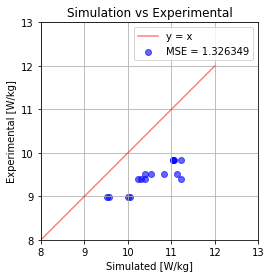

In [6]:

# make a figure for the simulations vs exp
f, ax = plt.subplots()
tempx = bothtrim_df['metabolics_all_avg_mean_x']
tempy = bothtrim_df['metabolics_all_avg_mean_y']
mse = mean_squared_error(tempy, tempx)
ax.scatter(tempx, tempy, marker='o', alpha=0.6, c='blue', label='MSE = %f'%mse)
# line = mlines.Line2D([0,1], [0,1], color='red')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)
unitx = np.linspace(8,12,100)
ax.plot(unitx,unitx,color='red',alpha=0.5, label='y = x')
# some nice 
ax.set_title('Simulation vs Experimental')
plt.xlim([8, 13])
plt.ylim([8, 13])
ax.set_aspect('equal', adjustable='box')
plt.grid()
plt.xlabel('Simulated [W/kg]')
plt.ylabel('Experimental [W/kg]')
plt.legend()
# plt.show()

In [7]:
# make a figure for exo vs natural stance and swing
# thinking box plots
# pdb.set_trace()

swingexo = np.array([])
swingnatural = np.array([])
stanceexo = np.array([])
stancenatural = np.array([])

# split the swings up
for i, row in swing_df.iterrows():
    # print(i)
    # print(row)
    tempcond = row['condname']
    if 'welkexo' in tempcond:
        swingexo = np.append(swingexo, row['metabolics_swing_avg_mean'])
    elif 'welknatural' in tempcond:
        swingnatural = np.append(swingnatural, row['metabolics_swing_avg_mean'])
for i, row in stance_df.iterrows():
    # print(i)
    # print(row)
    tempcond = row['condname']
    if 'welkexo' in tempcond:
        stanceexo = np.append(stanceexo, row['metabolics_stance_avg_mean'])
    elif 'welknatural' in tempcond:
        stancenatural = np.append(stancenatural, row['metabolics_stance_avg_mean'])


In [8]:
# function for setting the colors of the box plots pairs
def setBoxColors(bp):

    setp(bp['boxes'][1], color='blue')
    setp(bp['caps'][2], color='blue')
    setp(bp['caps'][3], color='blue')
    setp(bp['whiskers'][2], color='blue')
    setp(bp['whiskers'][3], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][1], color='blue')

    setp(bp['boxes'][0], color='red')
    setp(bp['caps'][0], color='red')
    setp(bp['caps'][1], color='red')
    setp(bp['whiskers'][0], color='red')
    setp(bp['whiskers'][1], color='red')
    setp(bp['fliers'][0], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['medians'][0], color='red')


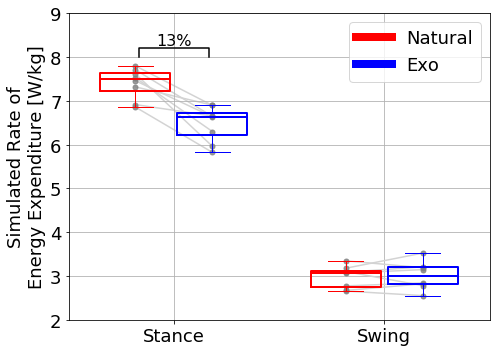

In [12]:
print("!!! Need to change this to only get the one leg and not the double !!!\n\n We really are only showing the results of one leg")

swings = [swingnatural, swingexo]
stances = [stancenatural, stanceexo]


# pdb.set_trace()
fig = figure(figsize=(7,5))
ax = axes()
#hold(True)

boxprops = dict(linewidth=2)
medianprops = dict(linewidth=2)
meanprops = dict(linewidth=2)
flierprops = dict(linewidth=2)


# first pair - stance
bp = boxplot(stances, positions=[0.95,2.05], widths=1, zorder=100, 
             boxprops=boxprops, 
             meanprops=meanprops, 
             medianprops=medianprops,
            flierprops=flierprops)
setBoxColors(bp)
# second pair - swing
bp = boxplot(swings, positions=[3.95,5.05], widths=1, zorder=105,
            boxprops=boxprops, 
             meanprops=meanprops, 
             medianprops=medianprops,
            flierprops=flierprops)
setBoxColors(bp)
# set axes limits and labels
xlim(0,6)
ylim(2,9)


ax.set_xticks([1.5, 4.5])
# ax.set_xticklabels(['Stance\n13% Reduction Avg.', 'Swing\n1% Increase Avg.'],fontsize=24)
ax.set_xticklabels(['Stance', 'Swing'],fontsize=18)
# ax.yticks(fontsize=24)
# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'r-', lw=8)
hR, = plot([1,1],'b-', lw=8)
plt.legend((hB, hR),('Natural', 'Exo'),fontsize=18)
plt.ylabel('Simulated Rate of\nEnergy Expenditure [W/kg]',fontsize=18)
plt.yticks(fontsize=18)
hB.set_visible(False)
hR.set_visible(False)
plt.grid()
colorsjit = ['red', 'blue']
for i in [1,2]: # ,4,5]:
    y = stances[i-1] # titanic.age[titanic.pclass==i].dropna()
    # Add some random "jitter" to the x-axis
    # x = np.random.normal(i, 0.0, size=len(y))
    x = [.95*np.ones(len(y)), 2.05*np.ones(len(y))]
    plot(x[i-1], y, '.', alpha=0.8, color='grey', zorder=4, markersize=10) # color=colorsjit[i-1])
for i in [4,5]:
    y = swings[i-4]
    # x = np.random.normal(i, 0.0, size=len(y))
    # need a different x value
    x = [3.95*np.ones(len(y)), 5.05*np.ones(len(y))]
    plot(x[i-4], y, '.', alpha=0.8, color='grey', zorder=3, markersize=10) # color=colorsjit[i-4])

# figure out subject lines across conditions
x_stances = [0.95*np.ones(len(stances[0])), 2.05*np.ones(len(stances[1]))]
x_swings = [3.95*np.ones(len(stances[0])), 5.05*np.ones(len(stances[1]))]

plot(x_stances, stances, color='lightgrey', zorder=1)
plot(x_swings, swings, color='lightgrey', zorder=2)

# now figure out the bracket
x1, x2 = 1,2
y, h, col =  8, 0.2, 'black'
plt.plot([x1,x1,x2,x2], [y, y+h, y+h, y], color=col)
plt.text((x1+x2)*.5, y+h, '13%', ha='center', va='bottom', color=col,
        fontsize=16)
plt.tight_layout()

fname = os.path.join(repobasedir, '..\\analysis\\figure1_stancevsswing.png')
plt.savefig(fname, dpi=300)

In [18]:
repobasedir

'G:\\Shared drives\\Exotendon\\muscleModel\\muscleEnergyModel'